<a href="https://colab.research.google.com/github/19IT124/19IT124_19IT125_IT356-CROWD_COMPUTING/blob/main/Preprocessing(CC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive to colab notebook
 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import json
import h5py             # https://pypi.org/project/h5py/
import PIL as image     # https://en.wikipedia.org/wiki/Python_Imaging_Library
import glob
import os
import scipy
from scipy import spatial
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import scipy.io as io 
from matplotlib import pyplot as plt
from matplotlib import cm as CM
from PIL import Image
import matplotlib.image as img 

In [ ]:
# List of all image paths
image_paths = []
prefix = '/content/gdrive/MyDrive/Crowd_computing/ShanghaiTech'
def create_image_paths():
  part_A_train = os.path.join(prefix,'part_A/train_data','images')
  # part_A_test = os.path.join(prefix,'part_A/test_data','images')
  # part_B_train = os.path.join(prefix,'part_B/train_data','images')
  # part_B_test = os.path.join(prefix,'part_B/test_data','images')
  main_paths = [part_A_train]

  for path in main_paths:
      for image_path in glob.glob(os.path.join(path, '*.jpg')):
          image_paths.append(image_path)
  print("part_A train_data ==>Total images : {}".format(len(image_paths)))

In [ ]:
def display_image(no):
    # image = Image.open(path)
    image = img.imread(image_paths[no-1]) 
    plt.imshow(image)
    plt.show()

In [ ]:
display_image(125)

In [ ]:
# def Gaussian_filter(ground_truth,img):
    
    # Generates a density map using Gaussian filter transformation   
    # density = np.zeros((img.shape[0],img.shape[1]), dtype=np.float32)
    
    # # gt_count = np.count_nonzero(ground_truth)
    
    # # if gt_count == 0:
    # #     return density
       
    # for i, p in enumerate(ground_truth):
    #     temp = np.zeros((img.shape[0],img.shape[1]), dtype=np.float32)
    #     temp[int(p[1]),int(p[0])] = 1.
        
    #     # pass through gaussian filter
    #     density += scipy.ndimage.filters.gaussian_filter(temp, sigma=2.5,mode='constant')    
    
    # return density
    
def Gaussian_filter(gt):
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [ ]:
with open(prefix+'/part_B/train_data/data.csv', 'w', encoding = 'utf-8') as f:
  f.write("Image_path,Y_pred,Y_truth\n")

In [ ]:
image_paths.clear()   # otherwise new paths will get appended
create_image_paths()

part_A train_data ==>Total images : 300


In [ ]:
cnt = 1
for img_path in image_paths[150:]:
    # print(image_path)
    # Load given sparse matrix
    # mat = io.loadmat(image_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG','GT_IMG'))
    # ground_truth = mat["image_info"][0,0][0,0][0]     # to understand this line go to below block

    # img= plt.imread(image_path)

    # # generate density map
    # g_filter= Gaussian_filter(ground_truth,img)

    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = Gaussian_filter(k)

    # Save density map
    path = img_path.replace('.jpg','.h5').replace('images','new_density_maps')
    
    with h5py.File(path, 'w') as f:
            f['density'] = k

    # save data into data.csv
    # path = image_path.replace('.jpg','.h5').replace('images','data.csv')
    # path = path[ : path.index(".csv") + 4]
    # with open(path, 'a', encoding = 'utf-8') as f:
    #     f.write("{},{},\n".format(image_path.replace('\\','/'),np.sum(g_filter)))

    print("{} - {} , {}".format(cnt,img_path,np.sum(k)))
    cnt += 1

1 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_41.jpg , 398.49578857421875
2 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_245.jpg , 479.2164611816406
3 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_281.jpg , 142.1326141357422
4 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_58.jpg , 1586.1123046875
5 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_299.jpg , 2160.392822265625
6 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_52.jpg , 1136.41748046875
7 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_34.jpg , 958.2593994140625
8 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_246.jpg , 367.6785888671875
9 - /content/gdrive/MyDrive/Crowd_computing/ShanghaiTech/part_A/train_data/images/IMG_29.jpg ,

In [ ]:
# ground-truth(.mat) file structure

mat
{   
    '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:05:04 2016', 
    '__version__': '1.0', 
    '__globals__': [],  
     
    """
        ### general structure  of image_info ###

        array1(
                [
                    [
                        array2(
                                [
                                    [
                                        (
                                            # array 2.1 is sparse matrix which is required to create density map of ground-truth
                                            array2.1( [ [ 524.17564209,  611.31179232],....,[  20.58878763,  594.48550124] ] ),
                                            array2.2( [ [277] ] )
                                        )
                                    ]
                                ]
                            )
                    ]
                ]
            )
    """
}

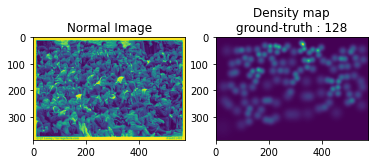

In [ ]:
image_name = "IMG_40"
dataset = "train_data"  # 'test_data'
part = 'part_A' # 'part_A'

with open(prefix+'/{}/{}/data.csv'.format(part,dataset), 'r', encoding = 'utf-8') as f1:
    data = f1.readlines()
    for row in data:
        if image_name in row:
            ground_truth = round(float(row.split(',')[1]),3)
            break

normal_image = img.imread(prefix+'/{}/{}/images/{}.jpg'.format(part,dataset,image_name)) 
plt.subplot(1,2,1)
plt.imshow(normal_image)
plt.title("Normal Image")

f = h5py.File(prefix+'/{}/{}/density_maps/{}.h5'.format(part,dataset,image_name),'r')

plt.subplot(1,2,2)
plt.imshow(np.asarray(f['density']))     # 'bwr'
# print(f['density'].shape)
plt.title("Density map\nground-truth : {}".format(int(np.sum(f['density']))))

plt.show()